In [1]:
import os
import torch
import collections
import json
import string
import re
import numpy as np
from tqdm.auto import tqdm

In [2]:
# get data json file
if not os.path.exists('./train-v2.0.json'):
    !wget -P './' https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

In [3]:
train_path = './train-v2.0.json'
f = open(train_path,'r')
data = json.load(f)
f.close()

In [4]:
# extract context, question, answer from original json file
def read_data(train=True):

    num_article = len(data['data'])
    if train:
        temp_data = data['data'][:(9*num_article//10)]
    else:
        temp_data = data['data'][(9*num_article//10):]
    
    contexts = []
    questions = []
    answers = []
    
    for article in temp_data:
        for p in article['paragraphs']:
            context = p['context']
            for qa in p['qas']:
                question = qa['question']

                contexts.append(context)
                questions.append(question)

                if qa['is_impossible']:
                    answers.append({'answer_start': 0, 'text': ''})
                else:
                    answers.append(qa['answers'][0])
    
    return contexts, questions, answers


# get the end char index for answers in the context
def add_end_idx(answers, contexts):

    for answer, context in zip(answers, contexts):

        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two, so we need
        # fix this

        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

In [5]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [6]:
def preprocess(contexts,questions,answers,train=True):
    context_list = []
    question_list = []

    start_position = []
    end_position = []

    for i in tqdm(range(len(contexts))):
        encoding = tokenizer(contexts[i])
        token_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)
        context_list.append(['[UNK]']+token_list)
        
        if train:
            if answers[i]['text'] == '':
                start_position.append(0)
                end_position.append(0)
            else:
                start = encoding.char_to_token(answers[i]['answer_start'])
                end = encoding.char_to_token(answers[i]['answer_end']-1)

                start_position.append(start)
                end_position.append(end)
    
    for i in tqdm(range(len(questions))):
        encoding = tokenizer(questions[i])
        token_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)

        question_list.append(token_list)

    if train:
        return context_list,question_list,start_position,end_position
    else:
        return context_list,question_list

In [ ]:
# get training data (90% of the original data)
train_contexts, train_questions, train_answers = read_data()
add_end_idx(train_answers, train_contexts)
train_context_list,train_question_list,train_start_position,train_end_position = preprocess(train_contexts,train_questions,train_answers)

In [7]:
# but actually due to the long time (about 5mins) of pre-processing,
# we directly save them into disk and load them when re-run the notebook
train_context_list = torch.load('./m1_data/train_context_list.pth')
train_question_list = torch.load('./m1_data/train_question_list.pth')
train_start_position = torch.load('./m1_data/train_start_position.pth')
train_end_position = torch.load('./m1_data/train_end_position.pth')
train_answers = torch.load('./m1_data/train_answers.pth')

In [24]:
# get validation data (10% of the original data)
val_contexts, val_questions, val_answers = read_data(train=False)
val_context_list,val_question_list = preprocess(val_contexts,val_questions,val_answers,train=False)

In [8]:
# or directly load them (as above)
val_context_list = torch.load('./m1_data/val_context_list.pth')
val_question_list = torch.load('./m1_data/val_question_list.pth')
val_answers = torch.load('./m1_data/val_answers.pth')

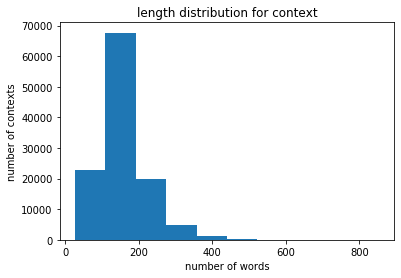

In [10]:
# here we do our data exploration on training set

import matplotlib.pyplot as plt

# the first thing we are interested in is the length of context/question
# because during batching we need to do truncation and padding
# choosing a proper length is important for performance and efficiency

length_list = []
for i in train_context_list:
    length_list.append(len(i))
plt.cla()
plt.hist(length_list)
plt.title('length distribution for context')
plt.ylabel("number of contexts")
plt.xlabel("number of words")
plt.show()

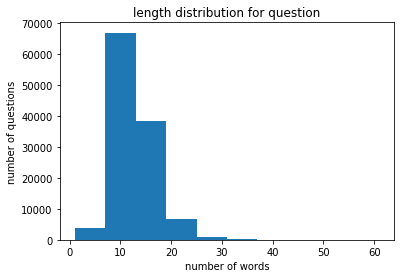

In [11]:
length_list = []
for i in train_question_list:
    length_list.append(len(i))
plt.cla()
plt.hist(length_list)
plt.title('length distribution for question')
plt.ylabel("number of questions")
plt.xlabel("number of words")
plt.show()

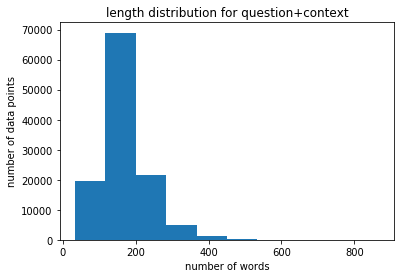

In [12]:
length_list = []
for i in range(len(train_question_list)):
    length_list.append(len(train_question_list[i])+len(train_context_list[i]))
plt.cla()
plt.hist(length_list)
plt.title('length distribution for question+context')
plt.ylabel("number of data points")
plt.xlabel("number of words")
plt.show()

In [13]:
# the second thing we are interested in is the percent of un-answered questions
total_count = len(train_answers)
na_count = 0
for i in range(total_count):
    if train_answers[i]['text']=='':
        na_count+=1
print('total questions: %d'%(total_count))
print('un-answered questions: %d'%na_count)
print('un-answered percent: %.2f'%(100*(na_count/total_count)))

total questions: 116897
un-answered questions: 39312
un-answered percent: 33.63


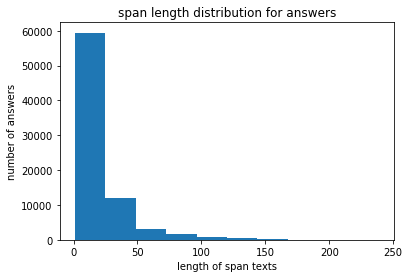

In [14]:
# the third thing we are interested in is the distribution of span length of answers
# this is important because it can serve as a threshold for determine answerbility
length_list = []
for i in train_answers:
    start = i['answer_start']
    end = i['answer_end']
    if start==0 and end==0:
        continue
    else:        
        length_list.append(end-start)
plt.cla()
plt.hist(length_list)
plt.title('span length distribution for answers')
plt.ylabel("number of answers")
plt.xlabel("length of span texts")
plt.show()

The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{# of matching tokens}}{\text{# of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{# of matching tokens}}{\text{# of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

In [15]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [16]:
# metric implementation here
def compute_exact(a_gold, a_pred):

    if normalize_answer(a_gold) == normalize_answer(a_pred):
        return 1
    else:
        return 0


def compute_f1(a_gold, a_pred):

    gold_tokens = get_tokens(a_gold)
    pred_tokens = get_tokens(a_pred)

    overlap = collections.Counter(gold_tokens) & collections.Counter(pred_tokens)
    num_overlap = sum(overlap.values())

    # if one of ground-truth and prediction is un-answered,
    # then F1 would be 1 if they are the same, otherwise be 0.
    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        if gold_tokens == pred_tokens:
            return 1
        else:
            return 0
    
    # if both are answered, just calculate F1 using the formula given above
    
    if num_overlap == 0:
        return 0

    precision = 1.0 * num_overlap / len(pred_tokens)
    recall = 1.0 * num_overlap / len(gold_tokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    return f1

# Naive implementation for DrQA

In [17]:
import gensim 
import gensim.downloader as api
word2vec = api.load("glove-wiki-gigaword-100")
embed_dim = 100

In [18]:
def sentence_to_tensor(sentence,length,unk):
    array = np.zeros((length, embed_dim))
    mask = np.zeros(length)

    for i in range(min(len(sentence),length)):
        w = sentence[i]
        mask[i]=1
        if len(w)>2 and w[:2]=='##':
            w = w[2:]
        if w in word2vec.vocab:
            array[i] = word2vec.get_vector(w)
        else:
            array[i] = unk
    
    tensor = torch.from_numpy(array.astype(np.float32))
    mask = torch.from_numpy(mask.astype(np.float32))
    return tensor,mask

In [19]:
context_length = 360
question_length = 40

class SquadDataset_m1(torch.utils.data.Dataset):
    
    def __init__(self, context_list, question_list, start_position, end_position):
        self.context_list = context_list
        self.question_list = question_list
        self.start_position = start_position
        self.end_position = end_position

        self.context_length = context_length
        self.question_length = question_length

        np.random.seed(42)
        self.unk = np.random.randn(embed_dim).astype(np.float32)

    def __getitem__(self, idx):
        context_tensor,context_mask = sentence_to_tensor(self.context_list[idx],self.context_length,self.unk)
        question_tensor,question_mask = sentence_to_tensor(self.question_list[idx],self.question_length,self.unk)
        start = min(self.start_position[idx],self.context_length-1)
        end = min(self.end_position[idx],self.context_length-1)
        return context_tensor,context_mask,question_tensor,question_mask,start,end

    def __len__(self):
        return len(self.context_list)

In [20]:
class SquadDataset_m1_val(torch.utils.data.Dataset):
    
    def __init__(self, context_list, question_list,answers):
        self.context_list = context_list
        self.question_list = question_list

        self.context_length = context_length
        self.question_length = question_length
        self.answers = answers

        np.random.seed(42)
        self.unk = np.random.randn(embed_dim).astype(np.float32)

    def __getitem__(self, idx):
        context_tensor,context_mask = sentence_to_tensor(self.context_list[idx],self.context_length,self.unk)
        question_tensor,question_mask = sentence_to_tensor(self.question_list[idx],self.question_length,self.unk)

        return context_tensor,context_mask,question_tensor,question_mask

    def __len__(self):
        return len(self.context_list)

In [21]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader,BatchSampler,SequentialSampler
def evaluate_m1_batch(model, dataset, return_list=False):
    with torch.no_grad():
        model.eval()
        device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)
        
        loader = DataLoader(dataset=dataset,sampler=SequentialSampler(dataset),batch_size=512, drop_last=False)

        start_list = []
        end_list = []
        for context_tensor,context_mask,question_tensor,question_mask in tqdm(loader): 
            start_score,end_score = model.get_scores(context_tensor.to(device),context_mask.to(device),
                                    question_tensor.to(device),question_mask.to(device))
            answer_start = torch.argmax(start_score,dim=1).cpu().tolist()
            answer_end = torch.argmax(end_score,dim=1).cpu().tolist()

            start_list.extend(answer_start)
            end_list.extend(answer_end)

        em = 0.0
        f1 = 0.0

        for i in range(len(dataset)):

            pred = ''
            
            answer_start = start_list[i]
            answer_end = end_list[i]
            temp_context_list = dataset.context_list[i]
            seq_length = len(temp_context_list)

            if answer_start == 0 or answer_end == 0 or answer_start>=(seq_length-1) or answer_end>=(seq_length-1):
                pred = ''
            
            elif answer_end < answer_start:
                pred = ''
            
            elif answer_end - answer_start > 20:
                pred = ''
            
            else:
                pred = temp_context_list[answer_start]

                for j in range(answer_start + 1, min(answer_end+1,len(temp_context_list))):
                    if len(temp_context_list[j])>2 and temp_context_list[j][0:2] == '##':
                        pred += temp_context_list[j][2:]
                    else:
                        pred += (' ' + temp_context_list[j])

            
            gold_text = dataset.answers[i]['text']

            em += compute_exact(gold_text,pred)
            f1 += compute_f1(gold_text,pred)
        
        em /= len(dataset)
        f1 /= len(dataset)

        print('EM: %.5f'%em)
        print('F1: %.5f'%f1)
        
        if return_list:
            return start_list,end_list

        return em, f1

In [22]:
import torch.nn as nn
class QA_align(nn.Module):
    def __init__(self,num_layers,input_size,hidden_size,dropout=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.context_rnn = nn.LSTM(input_size=2*input_size,hidden_size=hidden_size,num_layers=num_layers,bias=True,batch_first=True,dropout=dropout,bidirectional=True)
        self.question_rnn = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,bias=True,batch_first=True,dropout=dropout,bidirectional=True)
        self.att_vec = nn.Parameter(torch.randn(2*hidden_size),requires_grad=True)
        self.criterion = nn.CrossEntropyLoss()
        self.W_s = nn.Parameter(torch.randn(2*hidden_size,2*hidden_size),requires_grad=True)
        self.W_e = nn.Parameter(torch.randn(2*hidden_size,2*hidden_size),requires_grad=True)
        self.fc = nn.Linear(input_size,input_size)

    def get_att_output(self,input_tensor,input_mask,att_vec):
        temp = torch.matmul(input_tensor,att_vec) #batch,length
        temp = temp + (input_mask + 1e-45).log() # batch,length
        weight = nn.Softmax(dim=1)(temp) #batch,length
        weight = weight.unsqueeze(-1) # batch,length,1
        output = torch.sum(input_tensor*weight,dim=1) # batch,dim
        return output

    def forward(self,context_tensor,context_mask,question_tensor,question_mask,start_tensor,end_tensor):
        
        q = nn.ReLU()(self.fc(question_tensor))
        c = nn.ReLU()(self.fc(context_tensor))
        temp = torch.matmul(c,torch.transpose(q,1,2)) # batch,seq_c,seq_q
        temp_logits = temp + (question_mask.unsqueeze(1) + 1e-45).log()
        weight = nn.Softmax(2)(temp_logits) # batch,seq_c,seq_q
        c_align = torch.matmul(weight,question_tensor) # batch,seq_c,dim
        
        context_tensor = torch.cat((context_tensor,c_align),2)
        
        question_output = self.question_rnn(question_tensor)[0] #batch,length,dim
        context_output = self.context_rnn(context_tensor)[0] #batch,length,dim

        question_vec = self.get_att_output(question_output,question_mask,self.att_vec) # batch,dim

        start_vec = torch.matmul(question_vec,self.W_s) # batch,dim
        end_vec = torch.matmul(question_vec,self.W_e) # batch,dim

        start_logits = torch.matmul(context_output,start_vec.unsqueeze(2)).squeeze(-1) # batch,length
        start_logits = start_logits + (context_mask + 1e-45).log()

        end_logits = torch.matmul(context_output,end_vec.unsqueeze(2)).squeeze(-1) # batch,length
        end_logits = end_logits + (context_mask + 1e-45).log()

        start_loss = self.criterion(start_logits, start_tensor)
        end_loss = self.criterion(end_logits, end_tensor)
        loss = start_loss + end_loss

        return loss
    
    def get_scores(self,context_tensor,context_mask,question_tensor,question_mask):
        
        q = nn.ReLU()(self.fc(question_tensor))
        c = nn.ReLU()(self.fc(context_tensor))
        temp = torch.matmul(c,torch.transpose(q,1,2)) # batch,seq_c,seq_q
        temp_logits = temp + (question_mask.unsqueeze(1) + 1e-45).log()
        weight = nn.Softmax(2)(temp_logits) # batch,seq_c,seq_q
        c_align = torch.matmul(weight,question_tensor) # batch,seq_c,dim
        
        context_tensor = torch.cat((context_tensor,c_align),2)
        
        question_output = self.question_rnn(question_tensor)[0] #batch,length,dim
        context_output = self.context_rnn(context_tensor)[0] #batch,length,dim

        question_vec = self.get_att_output(question_output,question_mask,self.att_vec) # batch,dim

        start_vec = torch.matmul(question_vec,self.W_s) # batch,dim
        end_vec = torch.matmul(question_vec,self.W_e) # batch,dim

        start_logits = torch.matmul(context_output,start_vec.unsqueeze(2)).squeeze(-1) # [batch,length,dim]*[batch,dim,1] -> [batch,length,1]
        start_logits = start_logits + (context_mask + 1e-45).log()

        end_logits = torch.matmul(context_output,end_vec.unsqueeze(2)).squeeze(-1) # batch,length
        end_logits = end_logits + (context_mask + 1e-45).log()

        start_score = nn.Softmax(dim=1)(start_logits)
        end_score = nn.Softmax(dim=1)(end_logits)

        return start_score,end_score

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime

torch.cuda.empty_cache()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = QA_align(num_layers=3,input_size=embed_dim,hidden_size=embed_dim,dropout=0.5)
model.to(device)
model.train()

train_dataset = SquadDataset_m1(train_context_list, train_question_list, train_start_position, train_end_position)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=3, pin_memory=True)

val_dataset_m1 = SquadDataset_m1_val(val_context_list,val_question_list,val_answers)

optimizer = optim.Adam(model.parameters(),lr=1e-3)
save_path = './model_1_val_align.pth'

iter_counter = 0
best_f1 = 0
avg_loss = 0

for epoch in range(50):
    print('epoch %d start!'%(epoch+1))
    for context_tensor,context_mask,question_tensor,question_mask,start_tensor,end_tensor in train_loader:
        optimizer.zero_grad()
        loss = model(context_tensor.to(device),context_mask.to(device),question_tensor.to(device),
                     question_mask.to(device),start_tensor.to(device),end_tensor.to(device))
        loss.backward()
        optimizer.step()

        iter_counter += 1

        avg_loss += loss.item()

        if iter_counter%250 == 0:
            avg_loss /= 250
            print('iter %d'%iter_counter)
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            print('loss %.5f'%avg_loss)
            avg_loss = 0
            print()
        if iter_counter%1000 == 0:
            em,f1 = evaluate_m1_batch(model,val_dataset_m1)
            model.train()
            if f1>best_f1:
                best_f1 = f1
                torch.save(model.state_dict(), save_path)
                print('best model!')
            print()
    print('epoch %d finish!'%(epoch+1))

em,f1 = evaluate_m1_batch(model,val_dataset_m1)
if f1>best_f1:
    best_f1 = f1
    torch.save(model.state_dict(), save_path)
    print('best model!')



### Implementation Details

For the data pre-processing part, I first process all context/question into list of tokens. Then I use 100-dimension glove to get each token's corresponding word embedding. I also conduct truncation and padding to context/question. Contexts are truncated/padded into length 360 and questions into 40. It should be noted that for every context, it is pre-appended one '[UNK]' token at the beginning, which is used for answerbility prediction later. For padding, all padding tokens are zero tensors.

For the model itself, we basically follow the main idea of DrQA paper but without additional token features. For the question part, we feed sequence's word embedding into a 3-layer bi-directional LSTM with self-attention on top. So we can get a question vector which contains the semantic information of question. For the context part, we use concatenation of two things as each token's representation: its word embedding and its question aligned representation (as illustrated in DrQA paper). Then similar to what we do for questions, we feed them into a 3-layer bi-directional LSTM and use the last layer's output to represent each token. For span prediction, as shown in DrQA paper, we also apply a linear transformation to question vector to get two vectors: one for answer start and one for answer end. Then we use the product of answer start/end and context token LSTM representation to measure the similarity of start/end, i.e. the classification logits.

For the training, we apply cross-entropy loss to the logits and ground-truth labels (consists of softmax followed by log calculation). It should be noted that, for un-answered questions, we denote its label for answer start/end as 0, which is in fact the first '[UNK]' token we added during pre-processing. We use adam optimizer to train for 50 epochs and validate the model every 1000 iterations to get the best model.

For hyper-parameters, the dropout rate for LSTM is 0.5, initial lr is 1e-3, batch size is 64.

We mainly use the following two features:
1. the pre-trained glove word embedding. it has been shown that pre-trained word embedding contains useful semantic information for words and could be a good representation especially for training neural nets.
2. the question aligned representation, which turns out to be really crutial for good generalization. The intuition behind it is that it adds soft alignments between similar but non-identical words (e.g., car and vehicle). In our experiments, the F1 performance on validation set is only 34 without aligned repre, but could be as high as 50 after adding it.

## Validation Step



In [28]:
# overal validation on validation set
model_1 = QA_align(num_layers=3,input_size=embed_dim,hidden_size=embed_dim,dropout=0.5)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_1.to(device)
model_1.load_state_dict(torch.load('./model_1_val_align.pth'))
model_1.eval()

val_dataset_m1 = SquadDataset_m1_val(val_context_list,val_question_list,val_answers)
evaluate_m1_batch(model_1,val_dataset_m1)


EM: 0.43652
F1: 0.50853


(0.4365221278497988, 0.5085285763183762)

In [29]:
np.random.seed(42)
unk = np.random.randn(embed_dim).astype(np.float32)
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

def online_predict_m1(question, context):
    with torch.no_grad():
        encoding = tokenizer(context)
        context_list = ['[UNK]']+tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)
        
        encoding = tokenizer(question)
        question_list = tokenizer.convert_ids_to_tokens(encoding['input_ids'],skip_special_tokens=True)
        
        context_tensor,context_mask = sentence_to_tensor(context_list,context_length,unk)
        question_tensor,question_mask = sentence_to_tensor(question_list,question_length,unk)
        
        start_score,end_score = model_1.get_scores(context_tensor.unsqueeze(0).to(get_device()),
                                                 context_mask.unsqueeze(0).to(get_device()),
                                                 question_tensor.unsqueeze(0).to(get_device()),
                                                 question_mask.unsqueeze(0).to(get_device()))
        
        answer_start = torch.argmax(start_score.squeeze(0).cpu()).item()
        answer_end = torch.argmax(end_score.squeeze(0).cpu()).item()


        pred = ''

        seq_length = len(context_list)

        if answer_start == 0 or answer_end == 0 or answer_start>=(seq_length-1) or answer_end>=(seq_length-1):
            pred = ''

        elif answer_end < answer_start:
            pred = ''

        elif answer_end - answer_start > 20:
            pred = ''

        else:
            pred = context_list[answer_start]

            for j in range(answer_start + 1, min(answer_end+1,len(context_list))):
                if len(context_list[j])>2 and context_list[j][0:2] == '##':
                    pred += context_list[j][2:]
                else:
                    pred += (' ' + context_list[j])

        return pred, True

In [ ]:
hasans_em = []
hasans_f1 = []
noans_em = []
noans_f1 = []

for i in tqdm(range(len(val_questions))):
    pred,_ = online_predict_m1(val_questions[i],val_contexts[i])
    gold = val_answers[i]['text']
    if gold == '':
        noans_em.append(compute_exact(gold,pred))
        noans_f1.append(compute_f1(gold,pred))
    else:
        hasans_em.append(compute_exact(gold,pred))
        hasans_f1.append(compute_f1(gold,pred))

print('has-ans em: %.2f'%(100*np.mean(hasans_em)))
print('has-ans f1: %.2f'%(100*np.mean(hasans_f1)))
print('no-ans em: %.2f'%(100*np.mean(noans_em)))
print('no-ans f1: %.2f'%(100*np.mean(noans_f1)))

### Performance on validation set

| EM | F1 | HASANS_EM | HASANS_F1 | NOANS_EM | NOANS_F1 |
| :----:| :----: | :----: | :----: | :----: | :----: |  
| 43.65 | 50.85 | 34.00 | 44.46 | 64.95 | 64.95 |

In [30]:
for i in range(20):
    index = np.random.randint(10000)
    c = val_contexts[index]
    q = val_questions[index]
    p_rnn,_ = online_predict_m1(q,c)
    print('context:')
    print(c)
    print('question:')
    print(q)
    print('gold answer: %s'%val_answers[index]['text'])
    print('rnn answer: %s'%p_rnn)
    print()

context:
The propagation of universities was not necessarily a steady progression, as the 17th century was rife with events that adversely affected university expansion. Many wars, and especially the Thirty Years' War, disrupted the university landscape throughout Europe at different times. War, plague, famine, regicide, and changes in religious power and structure often adversely affected the societies that provided support for universities. Internal strife within the universities themselves, such as student brawling and absentee professors, acted to destabilize these institutions as well. Universities were also reluctant to give up older curricula, and the continued reliance on the works of Aristotle defied contemporary advancements in science and the arts. This era was also affected by the rise of the nation-state. As universities increasingly came under state control, or formed under the auspices of the state, the faculty governance model (begun by the University of Paris) became m

context:
Between 1832 and 2002 the currency of Greece was the drachma. After signing the Maastricht Treaty, Greece applied to join the eurozone. The two main convergence criteria were a maximum budget deficit of 3% of GDP and a declining public debt if it stood above 60% of GDP. Greece met the criteria as shown in its 1999 annual public account. On 1 January 2001, Greece joined the eurozone, with the adoption of the euro at the fixed exchange rate ₯340.75 to €1. However, in 2001 the euro only existed electronically, so the physical exchange from drachma to euro only took place on 1 January 2002. This was followed by a ten-year period for eligible exchange of drachma to euro, which ended on 1 March 2012.
question:
What did Greece sign to apply to join the eurozone?
gold answer: Maastricht Treaty
rnn answer: maastricht treaty

context:
Namibia conducts a census every ten years. After independence the first Population and Housing Census was carried out in 1991, further rounds followed in 